# Best practices workflow for preprocessing of single-cell RNA-seq data

This notebook presents a best practice workflow for the preprocessing of single-cell RNA-seq data. It is a simplified and slightly modified version of the [single-cell-tutorial](https://github.com/theislab/single-cell-tutorial) as presented in [Best practices in single-cell RNA-seq analysis: a tutorial](https://www.embopress.org/doi/10.15252/msb.20188746) by Luecken and Theis (2019).

The `scanpy` api gives access to all tools availalbe via the `scanpy` platform. `Numpy` and `scipy` are useful scientific computing libraries that are used by `scanpy`, and `pandas` is used to load in the data. `Pandas` is also the basis of the data structures used in `scanpy` (the `Anndata` module). `Matplotlib` and `seaborn` are used for plotting. R libraries that are used in this tutorial include `scran` for preprocessing

## Table of contents:

  * <a href=#Reading>1 Loading the data</a>
  * <a href=#Preprocessing>2 Pre-processing and visualization</a>
    * <a href=#QC>2.1 Quality Control</a>
    * <a href=#Normalization>2.2 Normalization</a> 
    * <a href=#Batch>2.3 Batch correction</a>
    * <a href=#HVG>2.4 Highly variable genes</a>
    * <a href=#Visualization>2.5 Visualization</a>
    * <a href=#CC>2.6 Cell cycle scoring</a>
  * <a href=#Downstream>3 Downstream analysis</a>
    * <a href=#Clustering>3.1 Clustering</a>
    * <a href=#Markers>3.2 Marker genes & cluster annotation</a>
    * <a href=#PAGA>3.3 Partition-based graph abstraction</a>
  * <a href=#Write>4 Store results</a>
  * <a href=#Summary>5 Summary</a>

### Import the libraries

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
import anndata2ri

# Ignore Python warning messages
import warnings
warnings.filterwarnings('ignore')

# to output data in sparse format
from scipy import sparse as scs

In [2]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()

scanpy==1.4.4 anndata==0.6.21 umap==0.3.9 numpy==1.16.4 scipy==1.3.0 pandas==0.25.0 scikit-learn==0.21.2 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


In [3]:
pip install anndata==0.6.21

     |████████████████████████████████| 61kB 1.0MB/s eta 0:00:01
  Stored in directory: /root/.cache/pip/wheels/52/02/d1/55d7f65320a36e17c20b78265e9f2ca60a5fb5970e97f8da50
Successfully built anndata
ERROR: scanpy 1.4.4 has requirement anndata>=0.6.22rc1, but you'll have anndata 0.6.21 which is incompatible.
  Found existing installation: anndata 0.6.22.post1
    Uninstalling anndata-0.6.22.post1:
      Successfully uninstalled anndata-0.6.22.post1
Note: you may need to restart the kernel to use updated packages.


In [3]:
%%R
# Load libraries from correct lib Paths for my environment - ignore this!
.libPaths(.libPaths()[c(3,2,1)])

# Load all the R libraries we will be using in the notebook
library(scran)
library(RColorBrewer)
# library(monocle)
# library(gam)
# library(clusterExperiment)
# library(ggplot2)
# library(plyr)
# library(MAST)

## Install FASTGenomics

In [4]:
!git clone https://github.com/FASTGenomics/fastgenomics-py.git

fatal: destination path 'fastgenomics-py' already exists and is not an empty directory.


In [5]:
import sys
sys.path.append('./fastgenomics-py')
from fastgenomics.external import anndata as fg_adata

# Load the data<a id="Reading"></a>

#### This section has to be adapted for the desired data set

For a test data set, we may load the Haber et al. data set retrieved from the Gene Expression Omnibus (GEO) via the ID GSE92332. These regional single cell expression data sets can be extracted from the GSE92332_RAW.tar file (https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE92332&format=file).

**Note** that single cell data exists in many formats and loading data may therefore require preprocessing. Packages like Scanpy and Seurat facilitate the data loading process by supporting several sparse and dense data formats in their read functions. When adapting this workflow to your own dataset, you will likely have to make changes to this section to match to the format of your data.

Here, we are reading in sparse count matrices, but are immediately converting these to dense representation with the .toarray() function. We create dense matrices as our batch correction method outputs a dense expression matrix, and the data transfer between R and python is currently limited to dense matrices. When sparse batch correction methods are available, and rpy2 is extended to sparse matrices, it is more memory-efficient to keep the data in a sparse format.

It should also be noted that the conventions for storing single cell data differ between R (Seurat, or Scater) and python platforms (Scanpy). Scanpy expects the data to be stored in the format cells x genes, while R platforms expect the transpose. As data is typically stored in the format genes x cells in the GEO, we must transpose the data before using it.

In [15]:
# Set up loading of test data set

#Data files
sample_strings = ['Duo_M1', 'Duo_M2', 'Jej_M1', 'Jej_M2', 'Il_M1', 'Il_M2']
sample_id_strings = ['3', '4', '5', '6', '7', '8']
data_dir = '../data/Haber-et-al_mouse-intestinal-epithelium/GSE92332_RAW/'
file_base = data_dir+'GSM283657'
exp_string = '_Regional_'
data_file_end = '_matrix.mtx'
barcode_file_end = '_barcodes.tsv'
gene_file_end = '_genes.tsv'
cc_genes_file = '../Macosko_cell_cycle_genes.txt'

In [16]:
# First data set load & annotation
#Parse Filenames
sample = sample_strings.pop(0)
sample_id = sample_id_strings.pop(0)
data_file = file_base+sample_id+exp_string+sample+data_file_end
barcode_file = file_base+sample_id+exp_string+sample+barcode_file_end
gene_file = file_base+sample_id+exp_string+sample+gene_file_end

#Load data
adata = sc.read(data_file, cache=False)
adata = adata.transpose()
adata.X = adata.X.toarray()

barcodes = pd.read_csv(barcode_file, header=None, sep='\t')
genes = pd.read_csv(gene_file, header=None, sep='\t')

#Annotate data
barcodes.rename(columns={0:'barcode'}, inplace=True)
barcodes.set_index('barcode', inplace=True)
adata.obs = barcodes
adata.obs['sample'] = [sample]*adata.n_obs
adata.obs['region'] = [sample.split("_")[0]]*adata.n_obs
adata.obs['donor'] = [sample.split("_")[1]]*adata.n_obs

genes.rename(columns={0:'gene_id', 1:'gene_symbol'}, inplace=True)
genes.set_index('gene_symbol', inplace=True)
adata.var = genes


--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


In [17]:
i=0
#Parse Filenames
sample = sample_strings[i]
sample_id = sample_id_strings[i]
data_file = file_base+sample_id+exp_string+sample+data_file_end
barcode_file = file_base+sample_id+exp_string+sample+barcode_file_end
gene_file = file_base+sample_id+exp_string+sample+gene_file_end

#Load data
adata_tmp = sc.read(data_file, cache=False)
adata_tmp = adata_tmp.transpose()
adata_tmp.X = adata_tmp.X.toarray()

barcodes_tmp = pd.read_csv(barcode_file, header=None, sep='\t')
genes_tmp = pd.read_csv(gene_file, header=None, sep='\t')

#Annotate data
barcodes_tmp.rename(columns={0:'barcode'}, inplace=True)
barcodes_tmp.set_index('barcode', inplace=True)
adata_tmp.obs = barcodes_tmp
adata_tmp.obs['sample'] = [sample]*adata_tmp.n_obs
adata_tmp.obs['region'] = [sample.split("_")[0]]*adata_tmp.n_obs
adata_tmp.obs['donor'] = [sample.split("_")[1]]*adata_tmp.n_obs

genes_tmp.rename(columns={0:'gene_id', 1:'gene_symbol'}, inplace=True)
genes_tmp.set_index('gene_symbol', inplace=True)
adata_tmp.var = genes_tmp
adata_tmp.var_names_make_unique()

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


In [23]:
tmp = adata.concatenate(adata_tmp, batch_key='sample_id')

In [24]:
tmp.var

,gene_id-0,gene_id-1
mm10_Xkr4,mm10_ENSMUSG00000051951,mm10_ENSMUSG00000051951
mm10_Gm1992,mm10_ENSMUSG00000089699,mm10_ENSMUSG00000089699
mm10_Gm37381,mm10_ENSMUSG00000102343,mm10_ENSMUSG00000102343
mm10_Rp1,mm10_ENSMUSG00000025900,mm10_ENSMUSG00000025900
mm10_Rp1-1,mm10_ENSMUSG00000109048,mm10_ENSMUSG00000109048
mm10_Sox17,mm10_ENSMUSG00000025902,mm10_ENSMUSG00000025902
mm10_Gm37323,mm10_ENSMUSG00000104328,mm10_ENSMUSG00000104328
mm10_Mrpl15,mm10_ENSMUSG00000033845,mm10_ENSMUSG00000033845
mm10_Lypla1,mm10_ENSMUSG00000025903,mm10_ENSMUSG00000025903
mm10_Gm37988,mm10_ENSMUSG00000104217,mm10_ENSMUSG00000104217


In [22]:
adata.var

,gene_id
mm10_Xkr4,mm10_ENSMUSG00000051951
mm10_Gm1992,mm10_ENSMUSG00000089699
mm10_Gm37381,mm10_ENSMUSG00000102343
mm10_Rp1,mm10_ENSMUSG00000025900
mm10_Rp1-1,mm10_ENSMUSG00000109048
mm10_Sox17,mm10_ENSMUSG00000025902
mm10_Gm37323,mm10_ENSMUSG00000104328
mm10_Mrpl15,mm10_ENSMUSG00000033845
mm10_Lypla1,mm10_ENSMUSG00000025903
mm10_Gm37988,mm10_ENSMUSG00000104217


In [9]:
# Loop to load rest of data sets
for i in range(len(sample_strings)):
    #Parse Filenames
    sample = sample_strings[i]
    sample_id = sample_id_strings[i]
    data_file = file_base+sample_id+exp_string+sample+data_file_end
    barcode_file = file_base+sample_id+exp_string+sample+barcode_file_end
    gene_file = file_base+sample_id+exp_string+sample+gene_file_end
    
    #Load data
    adata_tmp = sc.read(data_file, cache=False)
    adata_tmp = adata_tmp.transpose()
    adata_tmp.X = adata_tmp.X.toarray()

    barcodes_tmp = pd.read_csv(barcode_file, header=None, sep='\t')
    genes_tmp = pd.read_csv(gene_file, header=None, sep='\t')
    
    #Annotate data
    barcodes_tmp.rename(columns={0:'barcode'}, inplace=True)
    barcodes_tmp.set_index('barcode', inplace=True)
    adata_tmp.obs = barcodes_tmp
    adata_tmp.obs['sample'] = [sample]*adata_tmp.n_obs
    adata_tmp.obs['region'] = [sample.split("_")[0]]*adata_tmp.n_obs
    adata_tmp.obs['donor'] = [sample.split("_")[1]]*adata_tmp.n_obs
    
    genes_tmp.rename(columns={0:'gene_id', 1:'gene_symbol'}, inplace=True)
    genes_tmp.set_index('gene_symbol', inplace=True)
    adata_tmp.var = genes_tmp
    adata_tmp.var_names_make_unique()

    # Concatenate to main adata object
    adata = adata.concatenate(adata_tmp, batch_key='sample_id')
    adata.var['gene_id'] = adata.var['gene_id-1']
    adata.var.drop(columns = ['gene_id-1', 'gene_id-0'], inplace=True)
    adata.obs.drop(columns=['sample_id'], inplace=True)
    adata.obs_names = [c.split("-")[0] for c in adata.obs_names]
    adata.obs_names_make_unique(join='_')

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


Making variable names unique for controlled concatenation.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Note that this next line just cleans up the variable names which are stored as `mm10_` + MGI gene symbol in this dataset.

In [10]:
#Assign variable names and gene id columns
adata.var_names = [g.split("_")[1] for g in adata.var_names]
adata.var['gene_id'] = [g.split("_")[1] for g in adata.var['gene_id']]

Once the data is read in and annotated, we test whether we have the expected number of cells for each region, mouse (donor), and sample. **Note** that this step is specific for the Haber et al. (2017) data set.

In [11]:
# Annotate the data sets
print(adata.obs['region'].value_counts())
print('')
print(adata.obs['donor'].value_counts())
print('')
print(adata.obs['sample'].value_counts())

Duo    4554
Jej    4496
Il     4303
Name: region, dtype: int64

M2    6711
M1    6642
Name: donor, dtype: int64

Jej_M2    2668
Il_M1     2466
Duo_M1    2348
Duo_M2    2206
Il_M2     1837
Jej_M1    1828
Name: sample, dtype: int64


For the Haber et al. (2017) data set, we have 4554, 4496, and 4303 cells from the Duodenum, Jejunum, and Ileum respectively.

In [11]:
# Checking the total size of the data set
adata.shape

(13353, 27998)

For the Haber et al. (2017) data set, we have 13,353 cells and 27,998 genes in the dataset.

## Save data in FASTGenomics format

In [12]:
# dense to sparse matrix
smat = scs.coo_matrix(adata.X[:100,:].astype(int))

In [13]:
# map barcodes to cellID
bar2ind = adata.obs.reset_index()['index'].to_dict()
bar2ind = {y:x for x,y in bar2ind.items()}

In [14]:
# save expression matrix to tsv with columns
# cellId | geneId | expression
df = pd.DataFrame.from_dict(
        dict(
            cellId=adata.obs_names[smat.row].map(bar2ind),
            geneId=adata.var_names[smat.col],
            expression=smat.data,
        )
    )
df.to_csv(data_dir+'expression_data.tsv', sep='\t', index=False)

In [15]:
# save metadata to tsv with columns
# cellId | sample | region | donor
obs = adata.obs.set_index(adata.obs.index.map(bar2ind))
obs.index.rename('cellId', inplace=True)
obs.to_csv(data_dir+'cell_metadata.tsv', sep='\t', index=True)

In [16]:
adata.var.reset_index().rename(columns={'index': 'geneId', 'gene_id':'Ensembl_ID'}).to_csv(
    data_dir+'gene_metadata.tsv', sep='\t', index=False)

# Pre-processing and visualization<a id="Preprocessing"></a>

## Quality control<a id="QC"></a>

Data quality control can be split into cell QC and gene QC. Typical quality measures for assessing the quality of a cell include the number of molecule counts (UMIs), the number of expressed genes, and the fraction of counts that are mitochondrial. A high fraction of mitochondrial reads being picked up can indicate cell stress, as there is a low proportion of nuclear mRNA in the cell. It should be noted that high mitochondrial RNA fractions can also be biological signals indicating elevated respiration.

In [10]:
# Quality control - calculate QC covariates
adata.obs['n_counts'] = adata.X.sum(1)
adata.obs['log_counts'] = np.log(adata.obs['n_counts'])
adata.obs['n_genes'] = (adata.X > 0).sum(1)

mt_gene_mask = [gene.startswith('mt-') for gene in adata.var_names]
adata.obs['mt_frac'] = adata.X[:, mt_gene_mask].sum(1)/adata.obs['n_counts']

... storing 'donor' as categorical
... storing 'region' as categorical
... storing 'sample' as categorical


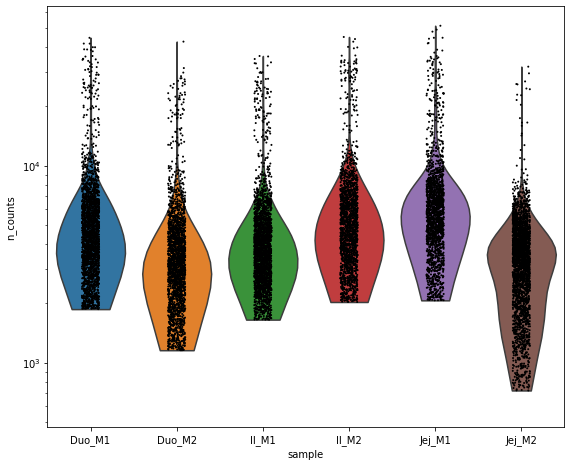

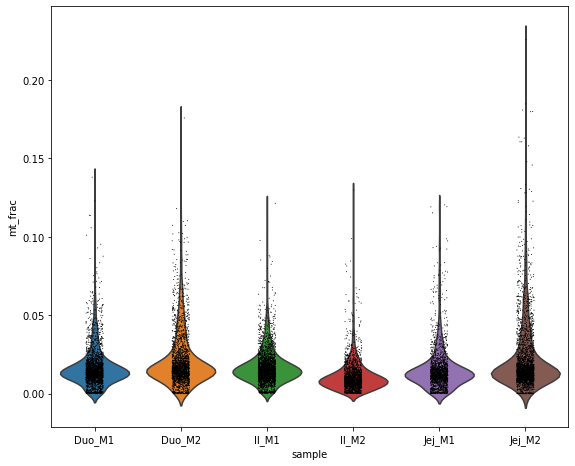

In [11]:
# Quality control - plot QC metrics
#Sample quality plots
t1 = sc.pl.violin(adata, 'n_counts', groupby='sample', size=2, log=True, cut=0)
t2 = sc.pl.violin(adata, 'mt_frac', groupby='sample')

These plots help to assess the quality of the data. Low quality is indicated by low cell counts and large fraction of mitochondrial reads (MT frac). Typical filtering thresholds for mitochondrial reads are 20-25%. If one sample has poorer quality cells, one could perform QC filtering per sample.

/home/ubuntu/anaconda3/envs/sc-tutorial/lib/python3.7/site-packages/scanpy/plotting/_anndata.py:311: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  x_arr = adata._get_obs_array(x, use_raw=use_raw, layer=layers[0])
/home/ubuntu/anaconda3/envs/sc-tutorial/lib/python3.7/site-packages/scanpy/plotting/_anndata.py:312: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  y_arr = adata._get_obs_array(y, use_raw=use_raw, layer=layers[1])


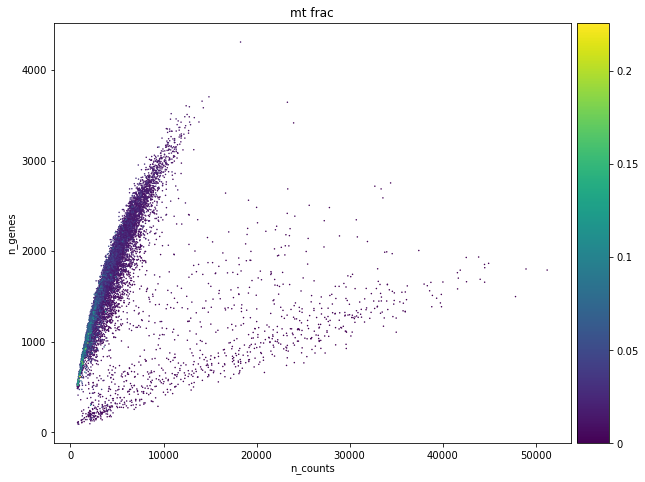

/home/ubuntu/anaconda3/envs/sc-tutorial/lib/python3.7/site-packages/scanpy/plotting/_anndata.py:311: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  x_arr = adata._get_obs_array(x, use_raw=use_raw, layer=layers[0])
/home/ubuntu/anaconda3/envs/sc-tutorial/lib/python3.7/site-packages/scanpy/plotting/_anndata.py:312: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  y_arr = adata._get_obs_array(y, use_raw=use_raw, layer=layers[1])


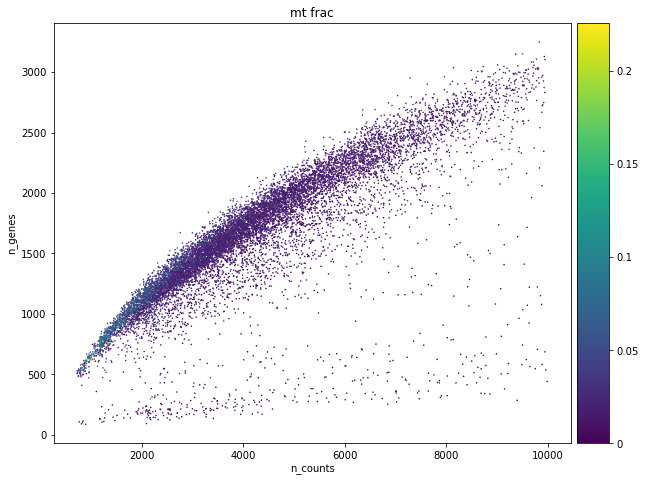

In [12]:
#Data quality summary plots
p1 = sc.pl.scatter(adata, 'n_counts', 'n_genes', color='mt_frac')
p2 = sc.pl.scatter(adata[adata.obs['n_counts']<10000], 'n_counts', 'n_genes', color='mt_frac')

By looking at plots of the number of genes versus the number of counts with MT fraction information, we can assess whether there are cells with unexpected summary statistics. It is important here to look at these statistics jointly. 

For example, if there is a cloud of points with many counts but few genes, our first instinct would be to filter these out as "dying" outliers. Such "dying" outliers should also be associated to high MT fractions.

Sometimes, cells with lower counts and genes tend to have higher fraction of mitochondrial counts. These cells are likely under stress or are dying. When apoptotic cells are sequenced, there is less mRNA to be captured in the nucleus, and therefore fewer counts overall, and thus a higher fraction of counts fall upon mitochondrial RNA. If cells with high mitochondrial activity were found at higher counts/genes per cell, this would indicate biologically relevant mitochondrial activity.

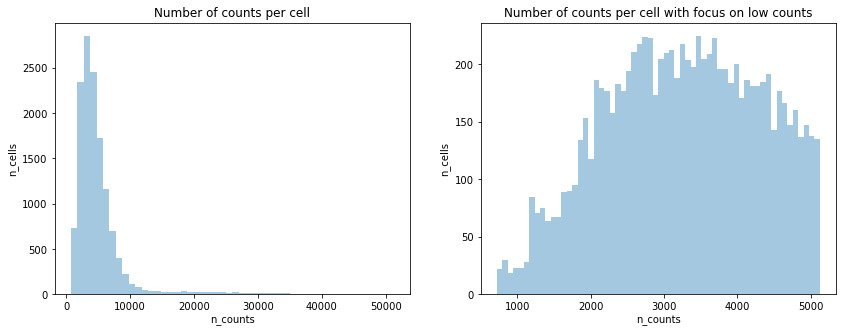

In [13]:
#Thresholding decision: counts
N = adata.obs['n_counts'].max()
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
p = sns.distplot(adata.obs['n_counts'], kde=False, ax=ax[0])
p.set_title('Number of counts per cell')
p.set_ylabel('n_cells')

p = sns.distplot(adata.obs['n_counts'][adata.obs['n_counts']<N/10], 
                  kde=False, bins=60, ax=ax[1])
p.set_title('Number of counts per cell with focus on low counts')
p.set_ylabel('n_cells')
plt.show()

Histograms of the number of counts per cell sometimes show peaks of groups of cells with relatively few counts (middle panel). Such groups may be cellular debris found in droplets.

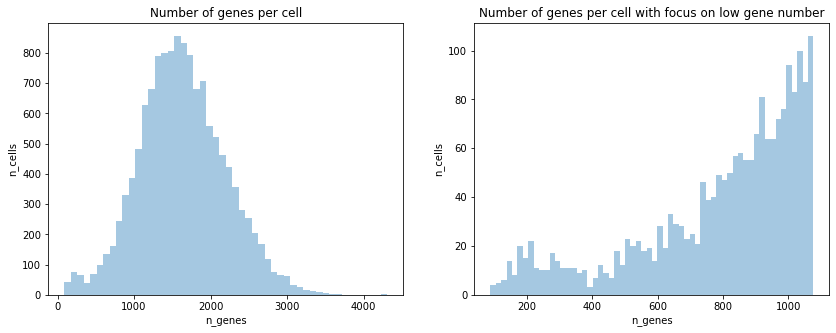

In [14]:
#Thresholding decision: genes
N = adata.obs['n_genes'].max()
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
p = sns.distplot(adata.obs['n_genes'], kde=False, ax=ax[0])
p.set_title('Number of genes per cell')
p.set_ylabel('n_cells')

p = sns.distplot(adata.obs['n_genes'][adata.obs['n_genes']<N/4], 
                  kde=False, bins=60, ax=ax[1])
p.set_title('Number of genes per cell with focus on low gene number')
p.set_ylabel('n_cells')
plt.show()


Sometimes, populations of cells with low gene counts can be seen in the above plots. These populations may be associated to dying cells or empty droplets with ambient RNA.

**Note**: In general it is a good idea to be permissive in the early filtering steps, and then come back to filter out more stringently when a clear picture is available of what would be filtered out. This is available after visualization/clustering. For demonstration purposes we stick to a simple (and slightly more stringent) filtering here.

### Filter out cells
**The parameters in this step have to be set according to the data set at hand.**

The filtering is performed based on the thresholds we identified from the QC plots. Genes are also filtered if they are not detected in at least 20 cells. This reduces the dimensions of the matrix by removing 0 count genes and genes which are not sufficiently informative of the dataset. 

In [15]:
# Filter cells according to identified QC thresholds:
print('Total number of cells: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_counts = 1500)
print('Number of cells after min count filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, max_counts = 40000)
print('Number of cells after max count filter: {:d}'.format(adata.n_obs))

adata = adata[adata.obs['mt_frac'] < 0.2]
print('Number of cells after MT filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_genes = 700)
print('Number of cells after gene filter: {:d}'.format(adata.n_obs))

Total number of cells: 13353
filtered out 479 cells that have less than 1500 counts
Number of cells after min count filter: 12874
filtered out 16 cells that have more than  40000 counts
Number of cells after max count filter: 12858
Number of cells after MT filter: 12858


Trying to set attribute `.obs` of view, making a copy.


filtered out 401 cells that have less than 700 genes expressed
Number of cells after gene filter: 12457


In [16]:
#Filter genes:
print('Total number of genes: {:d}'.format(adata.n_vars))

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata, min_cells=20)
print('Number of genes after cell filter: {:d}'.format(adata.n_vars))

Total number of genes: 27998
filtered out 15180 genes that are detected in less than 20 cells
Number of genes after cell filter: 12818


<a id="Normalization"></a>

## Normalization

Up to this point the data is only available as a count matrix. Counts are representative of molecules that were captured in the scRNA-seq experiment. As not all mRNA molecules in a cell are captured, there is a variability in the total number of counts detected between cells that results from both the number of molecules that were in the cells, and the sampling. As we cannot assume that all cells contain an equal number of molecules (cell sizes can differ substantially), we have to estimate the number of molecules that were initially in the cells. In fact, we don't estimate the exact number of molecules, but instead estimate cell-specific factors that should be proportional to the true number of molecules. These are called *size factors*. Normalized expression values are calculated by dividing the measured counts by the size factor for the cell.

Based on comparisons of normalization methods for differential testing (personal communication from Beathe Vieth), and batch correction [[Buettner et al., 2019](https://www.nature.com/articles/s41592-018-0254-1)], the normalization method implemented in the scran package performs best. This method requires a coarse clustering input to improve size factor esimation performance. Thus, we use a simple preprocessing approach and cluster the data at a low resolution to get an input for the size factor estimation. The basic preprocessing includes assuming all size factors are equal (library size normalization to counts per million - CPM) and log-transforming the count data.

**NOTE: The use of PCA in the cell below introduces randomness in the result that can lead to differences in the neighborhood graph. In turn, the Louvain clustering might lead to a different cluster population and/or a different number of clusters depending on the system, where the algorithm is calculated on (even if within a docker container).**

In [17]:
#Perform a clustering for scran normalization in clusters
adata_pp = adata.copy()
sc.pp.normalize_per_cell(adata_pp, counts_per_cell_after=1e6)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=15, svd_solver='arpack')
sc.pp.neighbors(adata_pp)
sc.tl.louvain(adata_pp, key_added='groups', resolution=0.5)

computing PCA with n_comps = 15
    finished (0:00:03.73)
computing neighbors
    using 'X_pca' with n_pcs = 15
    finished (0:00:09.25) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:02.39) --> found 10 clusters and added
    'groups', the cluster labels (adata.obs, categorical)


In [18]:
#Preprocess variables for scran normalization
input_groups = adata_pp.obs['groups']
data_mat = adata.X.T

In [19]:
%%R -i data_mat -i input_groups -o size_factors

size_factors = computeSumFactors(data_mat, clusters=input_groups, min.mean=0.1)

In [20]:
#Delete adata_pp
del adata_pp

/home/ubuntu/anaconda3/envs/sc-tutorial/lib/python3.7/site-packages/scanpy/plotting/_anndata.py:311: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  x_arr = adata._get_obs_array(x, use_raw=use_raw, layer=layers[0])
/home/ubuntu/anaconda3/envs/sc-tutorial/lib/python3.7/site-packages/scanpy/plotting/_anndata.py:312: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  y_arr = adata._get_obs_array(y, use_raw=use_raw, layer=layers[1])


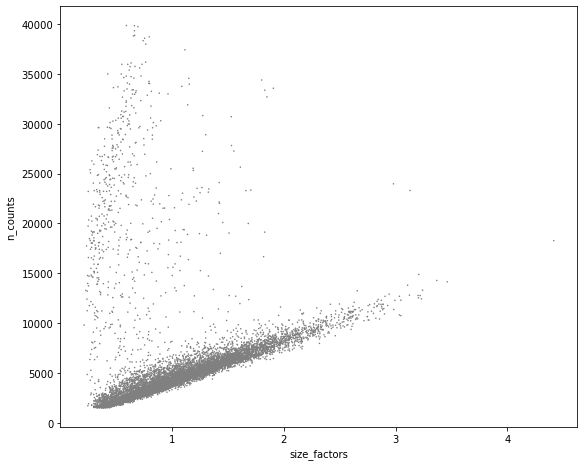

/home/ubuntu/anaconda3/envs/sc-tutorial/lib/python3.7/site-packages/scanpy/plotting/_anndata.py:311: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  x_arr = adata._get_obs_array(x, use_raw=use_raw, layer=layers[0])
/home/ubuntu/anaconda3/envs/sc-tutorial/lib/python3.7/site-packages/scanpy/plotting/_anndata.py:312: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  y_arr = adata._get_obs_array(y, use_raw=use_raw, layer=layers[1])


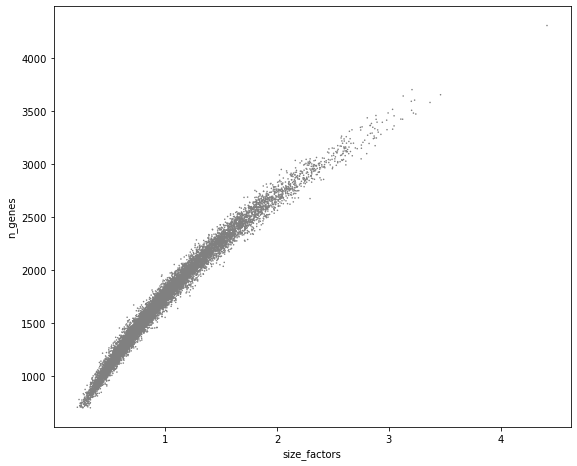

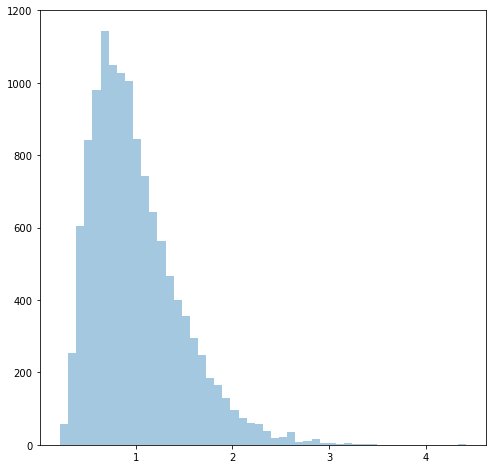

In [21]:
# Visualize the estimated size factors
adata.obs['size_factors'] = size_factors

sc.pl.scatter(adata, 'size_factors', 'n_counts')
sc.pl.scatter(adata, 'size_factors', 'n_genes')

sns.distplot(size_factors, bins=50, kde=False)
plt.show()

We plot the size factors to show they are non-negative and related to the number of counts and genes per cell as expected.

Before normalizing the data, we ensure that a copy of the raw count data is kept in a separate AnnData object. This allows us to use methods downstream that require this data as input.

In [22]:
#Keep the count data in a counts layer
adata.layers["counts"] = adata.X.copy()

In [23]:
#Normalize adata 
adata.X /= adata.obs['size_factors'].values[:,None]
sc.pp.log1p(adata)

In [24]:
# Store the full data set in 'raw' as log-normalised data for statistical testing
adata.raw = adata

The count data has been normalized and log-transformed with an offset of 1. The latter is performed to normalize the data distributions. The offset of 1 ensures that zero counts map to zeros. We keep this data in the '.raw' part of the AnnData object as it will be used to visualize gene expression and perform statistical tests such as computing marker genes for clusters.

<a id="Batch"></a>

## Batch Correction

**Depending on the data set at hand, the user may need to apply batch correction.**

For the test dataset (Haber et al., 2017), batch correction is performed to adjust for batch effects from the 6 samples that were loaded. As the batch effect from samples and from epithelium regions are overlapping, correcting for this batch effect will also partially regress out differences between regions. We allow for this to optimally cluster the data. This approach can also be helpful to find differentiation trajectories, but we revert back to non-batch-corrected data for differential testing and computing marker genes.

Note that ComBat batch correction requires a dense matrix format as input (which is already the case in this example).

In [25]:
# ComBat batch correction
sc.pp.combat(adata, key='sample')

Standardizing Data across genes.

Found 6 batches

Found 0 numerical variables:
	

Fitting L/S model and finding priors

Finding parametric adjustments

Adjusting data



Note ComBat batch correction can produce negative expression values. One can either set all negative values to 0 or force zeros pre-batch-correction to remain zero post-batch-correction. For simplicity we opt not to do this here.

## Highly Variable Genes<a id="HVG"></a>

We extract highly variable genes (HVGs) to further reduce the dimensionality of the dataset and include only the most informative genes. Genes that vary substantially across the dataset are informative of the underlying biological variation in the data. As we only want to capture biological variation in these genes, we select highly variable genes after normalization and batch correction. HVGs are used for clustering, trajectory inference, and dimensionality reduction/visualization, while the full data set is used for computing marker genes, differential testing, cell cycle scoring, and visualizing expression values on the data.

Here we use a standard technique for the extraction of highly variable genes from the 10X genomics preprocessing software CellRanger. Typically between 1000 and 5000 genes are selected. Here, we extract the top 4000 most variable genes for further processing. If particular genes of importance are known, one could assess how many highly variable genes are necessary to include all, or the majority, of these.

In [26]:
sc.pp.highly_variable_genes(adata, flavor='cell_ranger', n_top_genes=4000)
print('\n','Number of highly variable genes: {:d}'.format(np.sum(adata.var['highly_variable'])))

--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)

 Number of highly variable genes: 3999


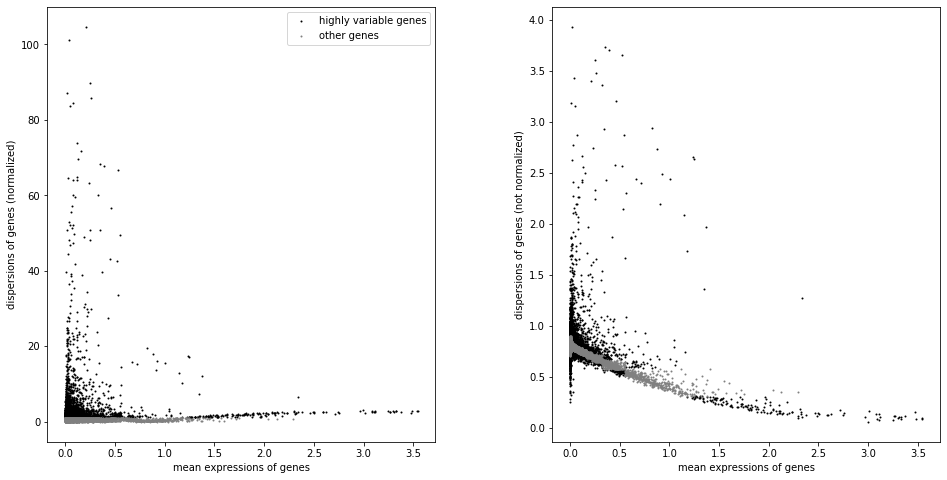

In [27]:
sc.pl.highly_variable_genes(adata)

The plots show how the data was normalized to select highly variable genes irrespective of the mean expression of the genes. This is achieved by using the index of dispersion which divides by mean expression, and subsequently binning the data by mean expression and selecting the most variable genes within each bin.

Highly variable gene information is stored automatically in the `adata.var['highly_variable']` field. The dataset now contains:
- a 'counts' layer with count data
- log-normalized data in adata.raw
- batch corrected data in adata.X
- highly variable gene annotations in `adata.var['highly_variable']`

The HVG labels will be used to subselect genes for clustering and trajectory analysis.

## Visualization<a id="Visualization"></a>

Visualizing scRNA-seq data is the process of projecting a high-dimensional matrix of cells and genes into a few coordinates such that every cell is meaningfully represented in a two-dimensional graph. However, the visualization of scRNA-seq data is an active area of research and each method defines 'meaningful' in its own way. Thus, it is a good idea to look at several visualizations and decide which visualization best represents the aspect of the data that is being investigated. 

Overall t-SNE visualizations have been very popular in the community, however the recent UMAP algorithm has been shown to better represent the topology of the data.

Note that we do not scale the genes to have zero mean and unit variance. A lack of rescaling is equivalent to giving genes with a higher mean expression a higher weight in dimensionality reduction (despite correcting for mean offsets in PCA, due to the mean-variance relationship). We argue that this weighting based on mean expression being a biologically relevant signal. However, rescaling HVG expression is also common, and the number of publications that use this approach suggests that scaling is at least not detrimental to downstream scRNA-seq analysis.

In [28]:
# Calculate the visualizations
sc.pp.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack')
sc.pp.neighbors(adata)

sc.tl.tsne(adata, n_jobs=12) #Note n_jobs works for MulticoreTSNE, but not regular implementation)
sc.tl.umap(adata)
sc.tl.diffmap(adata)
sc.tl.draw_graph(adata)

computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:10.00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:03.68) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix
computing tSNE
    using 'X_pca' with n_pcs = 50
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished (0:00:49.71) --> added
    'X_tsne', tSNE coordinates (adata.obsm)
computing UMAP
    using 'X_pca' with n_pcs = 50
    finished (0:00:12.61) --> added
    'X_umap', UMAP coordinates (adata.obsm)
computing Diffusion Maps using n_comps=15(=n_dcs)
    eigenvalues of transition matrix
    [1.         0.9969204  0.99411404 0.9931123  0.99228626 0.99164087
     0.9790914  0.9782719  0.97275984 0.970743   0.96867067 0.96484405
     0.9603231  0.9600635  0.9525198 ]
    finished (0:00:00.29) --> added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals',

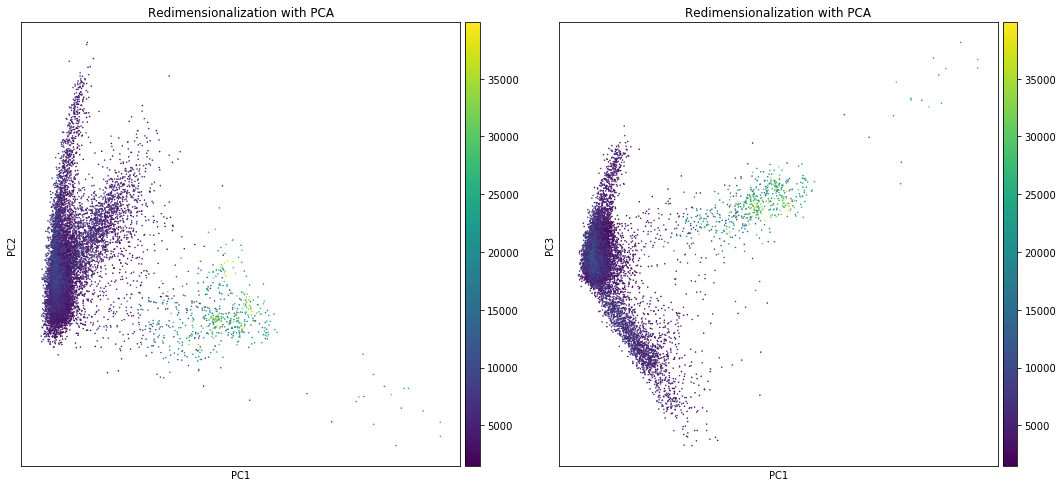

In [29]:
sc.pl.pca_scatter(adata, 
                  color='n_counts', 
                  components=['1,2','1,3'], 
                  title=['Redimensionalization with PCA']*2)

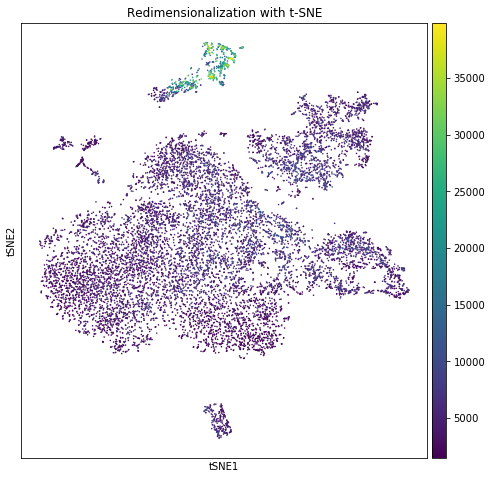

In [30]:
sc.pl.tsne(adata, color='n_counts', title='Redimensionalization with t-SNE')

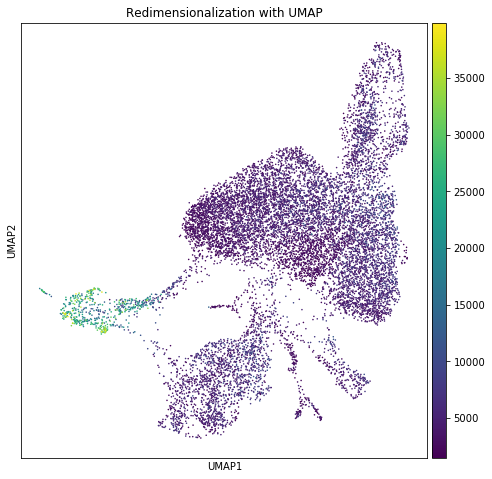

In [31]:
sc.pl.umap(adata, color='n_counts', title='Redimensionalization with UMAP')

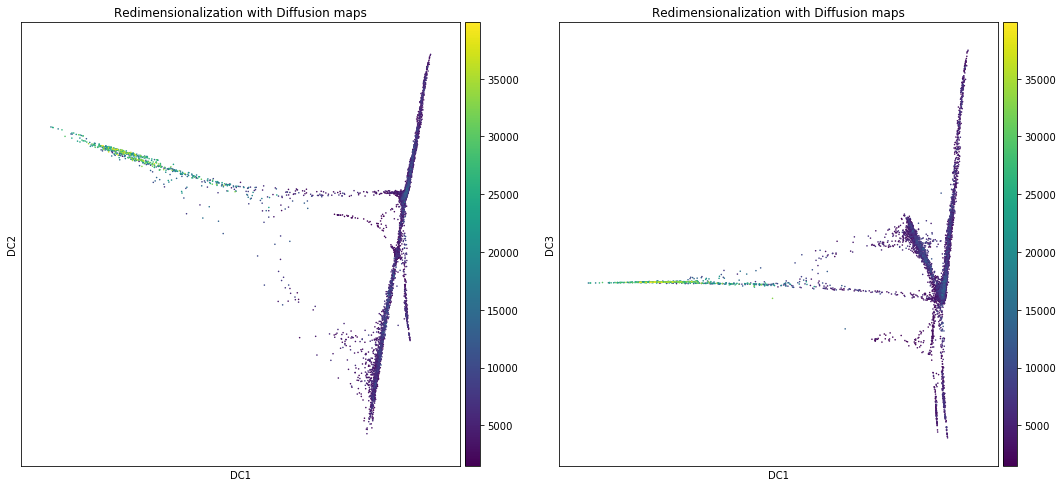

In [32]:
sc.pl.diffmap(adata, 
              color='n_counts', 
              components=['1,2','1,3'], 
              title=['Redimensionalization with Diffusion maps']*2)

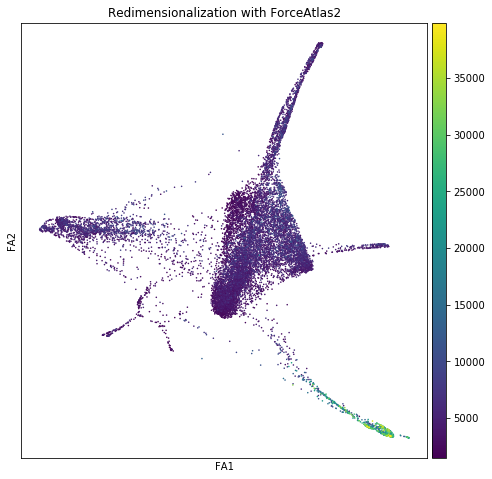

In [33]:
sc.pl.draw_graph(adata, color='n_counts', title='Redimensionalization with ForceAtlas2')

The strengths and weaknesses of the visualizations can readily be identified in the above plots. While t-SNE exaggerates differences, diffusion maps exaggerate transitions. Overall UMAP and force-directed graph drawings show the best compromise of the two aspects, however UMAP is much faster to compute. UMAP has furthermore been shown to more accurately display the structure in the data.

<a id="CC"></a>

## Cell cycle scoring

Known sources of technical variation in the data have been investigated and corrected for (e.g. batch, count depth). A known source of biological variation that can explain the data is the cell cycle. Here, a gene list from Macosko et al., Cell 161 (2015) is used to score the cell cycle effect in the data and classify cells by cell cycle phase. The file can be found on the [single-cell-tutorial github repository](https://github.com/theislab/single-cell-tutorial), or be taken from the supplementary material of [Luecken and Theis, 2019](https://www.embopress.org/doi/10.15252/msb.20188746).

Please note, that the gene list was generated for human HeLa cells, the gene names are put into lower case with a leading capital letter to map to the respective mouse genes. When adapting this script to your own data, this must be taken into account for data from species other than mouse.

We perform cell cycle scoring on the full batch-corrected data set in adata.

In [34]:
#Score cell cycle and visualize the effect:
cc_genes = pd.read_table(cc_genes_file, delimiter='\t')
s_genes = cc_genes['S'].dropna()
g2m_genes = cc_genes['G2.M'].dropna()

s_genes_mm = [gene.lower().capitalize() for gene in s_genes]
g2m_genes_mm = [gene.lower().capitalize() for gene in g2m_genes]

s_genes_mm_ens = adata.var_names[np.in1d(adata.var_names, s_genes_mm)]
g2m_genes_mm_ens = adata.var_names[np.in1d(adata.var_names, g2m_genes_mm)]

sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes_mm_ens, g2m_genes=g2m_genes_mm_ens)

calculating cell cycle phase
computing score 'S_score'
    finished (0:00:01.67) --> added
    'S_score', score of gene set (adata.obs)
computing score 'G2M_score'
    finished (0:00:02.48) --> added
    'G2M_score', score of gene set (adata.obs)
-->     'phase', cell cycle phase (adata.obs)


... storing 'phase' as categorical


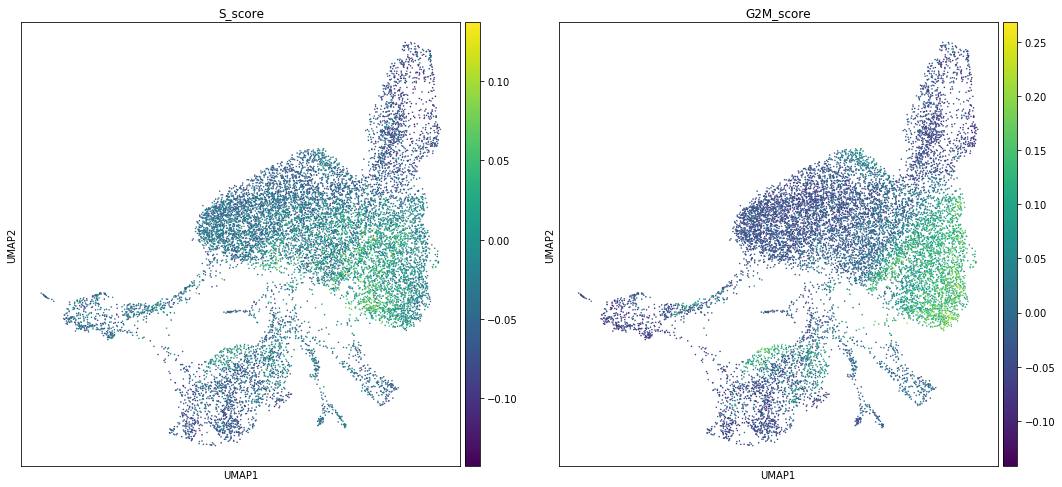

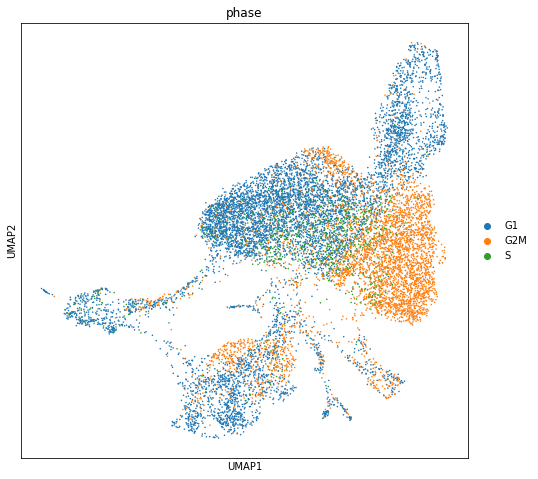

In [35]:
sc.pl.umap(adata, color=['S_score', 'G2M_score'], use_raw=False)
sc.pl.umap(adata, color='phase', use_raw=False)

Cell cycle scoring may show a pronounced proliferation signal in the Umap representation of the data and may suggest a proliferation phenotype in the associated cells.

<a id="Downstream"></a>

# Downstream analysis

## Clustering<a id="Clustering"></a>

Clustering is a central component of the scRNA-seq analysis pipeline. To understand the data, we must identify cell types and states present. The first step of doing so is clustering. Performing Modularity optimization by Louvain community detection on the k-nearest-neighbour graph of cells has become an established practice in scRNA-seq analysis.

Here, we perform clustering at two resolutions. Investigating several resolutions allows us to select a clustering that appears to capture the main clusters in the visualization and can provide a good baseline for further subclustering of the data to identify more specific substructure.

Clustering is performed on the highly variable gene data, dimensionality reduced by PCA, and embedded into a KNN graph. (see `sc.pp.pca()` and `sc.pp.neighbors()` functions used in the visualization section. **Note that PCA introduces randomness in the data.**

Modularity optimization via louvain has a stochastic element to it. This stochasticity typically does not affect the biological interpretation of the data, but can change the details of analysis scripts. Normally scanpy fixes the random seed to 0 to make scripts exactly reproducible. Regarding the stochasticity, the best approach would be a consensus clustering across many random seeds.

In [36]:
# Perform clustering - using highly variable genes
sc.tl.louvain(adata, resolution=1., key_added='louvain_r1')
sc.tl.louvain(adata, resolution=0.5, key_added='louvain_r0.5')

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:01.58) --> found 14 clusters and added
    'louvain_r1', the cluster labels (adata.obs, categorical)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:01.75) --> found 9 clusters and added
    'louvain_r0.5', the cluster labels (adata.obs, categorical)


In [37]:
adata.obs['louvain_r0.5'].value_counts()

0    2525
1    2036
2    1935
3    1797
4    1691
5    1270
6     683
7     274
8     246
Name: louvain_r0.5, dtype: int64

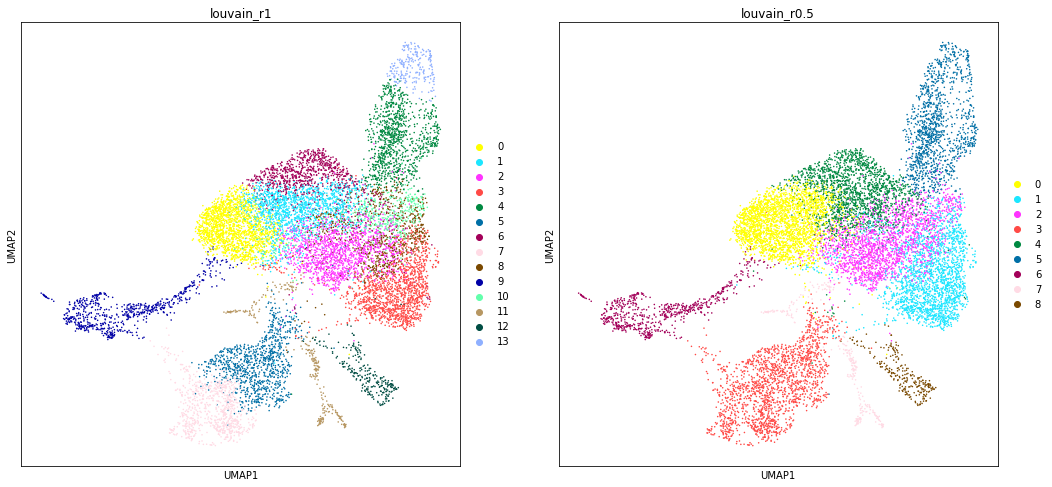

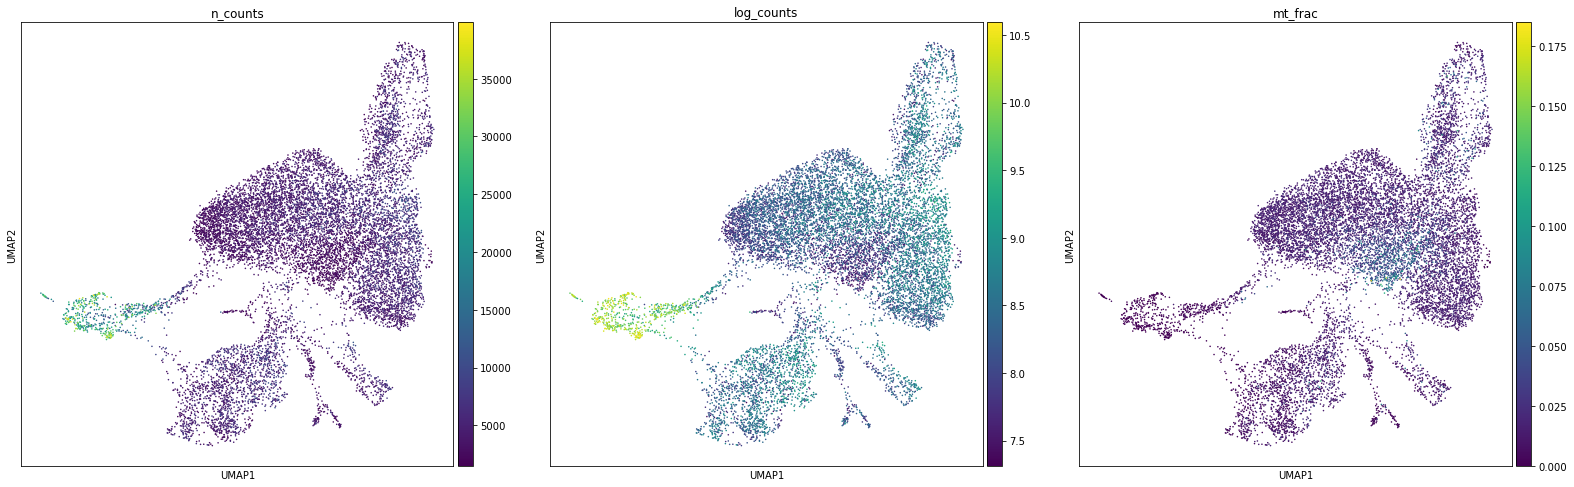

In [38]:
#Visualize the clustering and how this is reflected by different technical covariates
sc.pl.umap(adata, color=['louvain_r1', 'louvain_r0.5'], palette=sc.pl.palettes.default_64)
sc.pl.umap(adata, color=['n_counts', 'log_counts', 'mt_frac'])

<a id="Markers"></a>

## Marker genes & cluster annotation

To annotate the clusters we obtained, we find genes that are up-regulated in the cluster compared to all other clusters (marker genes). This differential expression test is performed by a Welch t-test with overestimated variance to be conservative. This is the default in scanpy. The test is automatically performed on the `.raw` data set, which is uncorrected and contains all genes. All genes are taken into account, as any gene may be an informative marker.

If there is only one reference atlas to annotate the cells, it is not necessary to use *scmap* [[Kiselev et al., 2018](https://www.nature.com/articles/nmeth.4644)] or *Garnett* [[Pliner et al., 2019](https://www.biorxiv.org/content/10.1101/538652v1)].

In [39]:
#Calculate marker genes
sc.tl.rank_genes_groups(adata, groupby='louvain_r0.5', key_added='rank_genes_r0.5')

ranking genes
    finished (0:00:06.16) --> added to `.uns['rank_genes_r0.5']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids


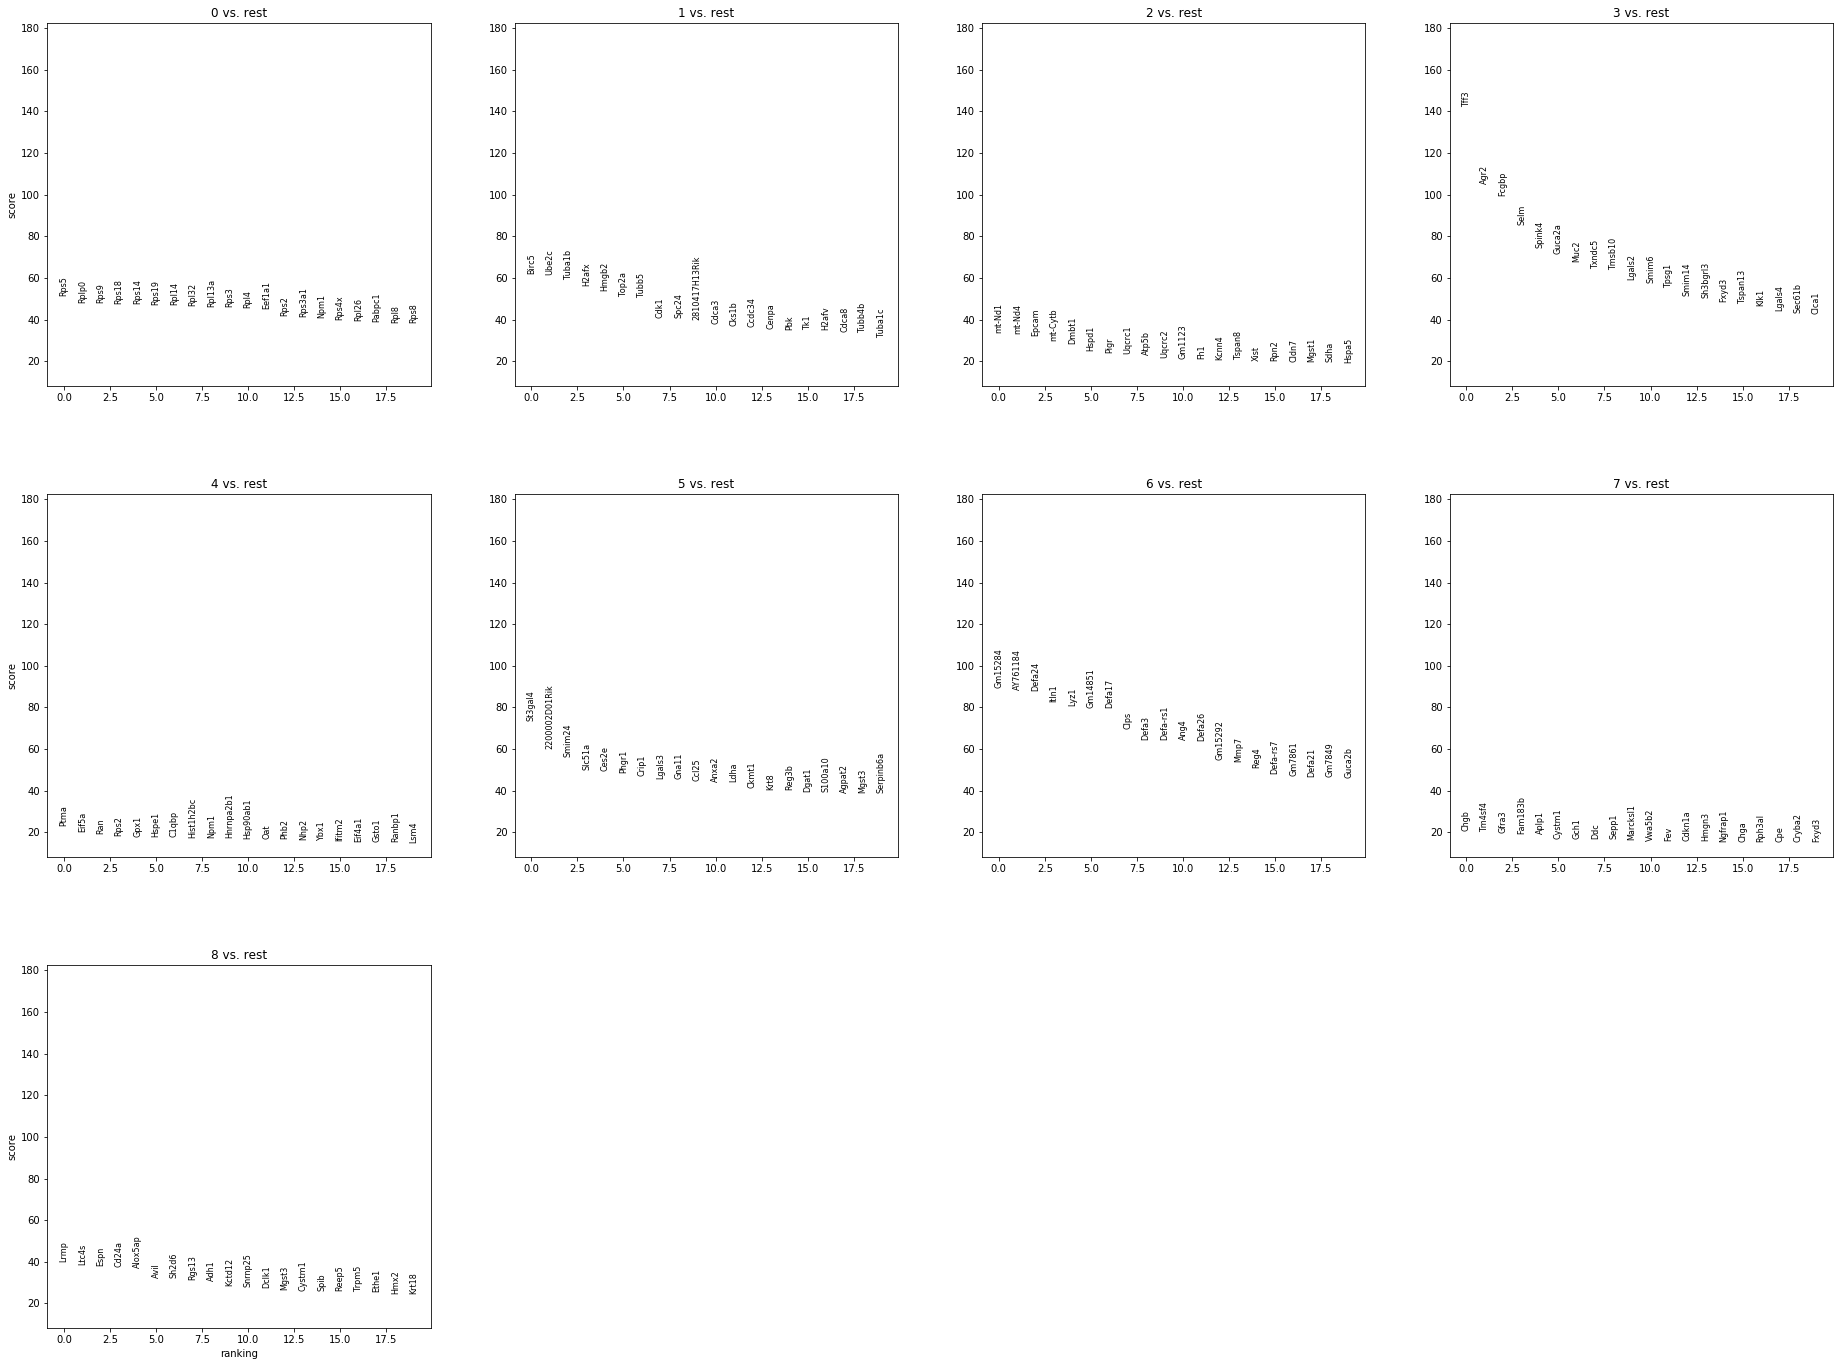

In [40]:
#Plot marker genes
sc.pl.rank_genes_groups(adata, key='rank_genes_r0.5')

The marker gene plots may help to identify clusters that are characterized by high expression of mitochondrial genes. Together with the low counts this suggests a 'stressed' phenotype.

To further identify the clusters, one may look at the overlap with a list of known marker genes. In practice marker gene sets can be obtained from public databases such as Linnarson's mouse brain atlas, various Human Cell Atlas datasets, and other published reference atlases. It should be noted that marker genes may not always overlap as expected given that atlases tend to be investigated under wild-type conditions.

#### Further analyses based on marker genes
At this point, we refer the user to the [single-cell-tutorial](https://github.com/theislab/single-cell-tutorial) git repository by Luecken and Theis (2019), where a detailed analysis based on marker genes is performed on the test dataset (Haber et al., 2017).

<a id="PAGA"></a>

## Partition-based graph abstraction

Partition-based graph abstraction (PAGA) is a method to reconcile clustering and pseudotemporal ordering. It can be applied to an entire dataset and does not assume that there are continuous trajectories connecting all clusters.

As PAGA is integrated into scanpy, we can easily run it on the entire data set. Here we run and visualize PAGA with different clustering inputs.

In [41]:
adata.obs['louvain_r0.5'].value_counts()

0    2525
1    2036
2    1935
3    1797
4    1691
5    1270
6     683
7     274
8     246
Name: louvain_r0.5, dtype: int64

running PAGA
    finished (0:00:00.39) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
--> added 'pos', the PAGA positions (adata.uns['paga'])


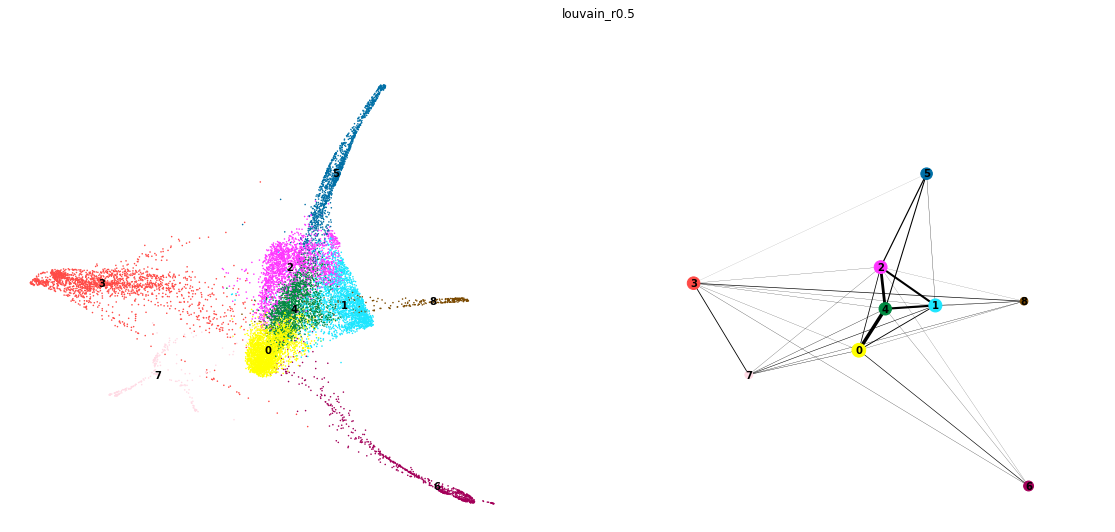

--> added 'pos', the PAGA positions (adata.uns['paga'])


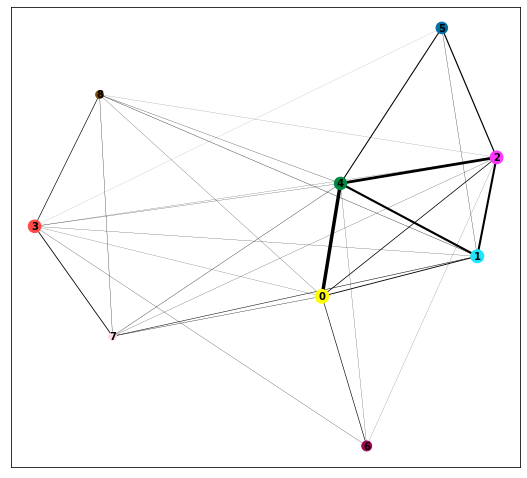

In [42]:
sc.tl.paga(adata, groups='louvain_r0.5')
sc.pl.paga_compare(adata)
sc.pl.paga(adata)

In the plot, stronger links between clusters are visualized by thicker lines. We can interpret this as transcriptional similarity between these clusters. Connections in PAGA may not only represent differentiation trajectories, but also transcriptional similarity between states. Thus, further experiments are required to confirm potential lineage trajectories obtained via PAGA or other trajectory inference methods.

We can do the same visualization on a umap layout.

--> added 'pos', the PAGA positions (adata.uns['paga'])


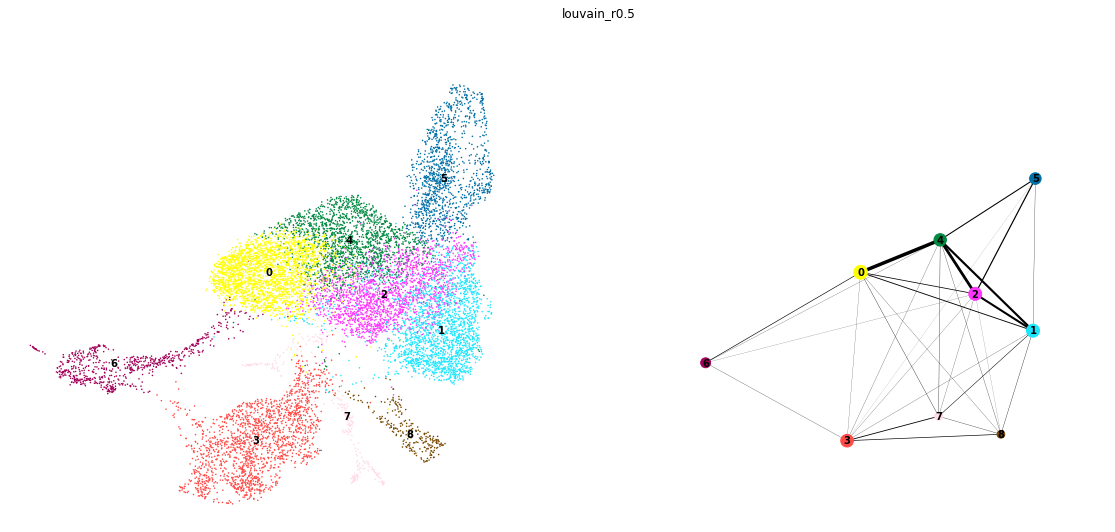

In [43]:
sc.pl.paga_compare(adata, basis='umap')

--> added 'pos', the PAGA positions (adata.uns['paga'])


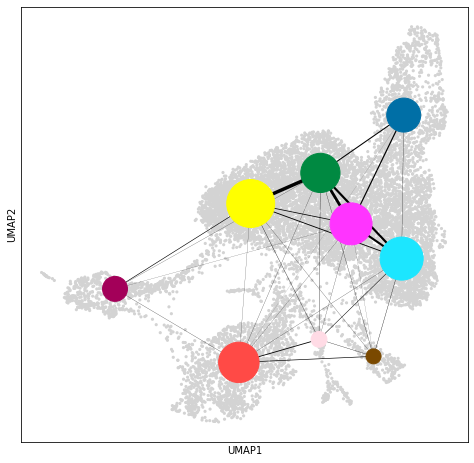

In [44]:
fig1, ax1 = plt.subplots()
sc.pl.umap(adata, size=40, ax=ax1, show=False)
sc.pl.paga(adata, pos=adata.uns['paga']['pos'], show=False, node_size_scale=10, node_size_power=1, ax=ax1, text_kwds={'alpha':0})
#plt.savefig('./figures/umap_paga_overlay_gut.pdf', dpi=300, format='pdf')
plt.show()

Implementation note:
- Note that the above plotting function only works when `sc.pl.paga_compare(adata, basis='umap')` is run before. The `sc.pl.paga_compare()` function stores the correct positions in `adata.uns['paga']['pos']` to overlay the PAGA plot with a umap representation. To overlap PAGA with other representation, you can run `sc.pl.paga_compare()` with other `basis` parameters before plotting the combined plot.

#### Regressing out counts and using non-batch corrected data
We show here how we can improve the inference results by regressing out counts and using non-batch corrected data.

In [ ]:
# #Create new Anndata object with non-batch corrected data
# adata_test = adata.copy()
# adata_test.X = adata.raw.X

In [ ]:
# #Regress out counts and redo pre-processing
# sc.pp.regress_out(adata_test, 'n_counts')
# sc.pp.pca(adata_test, use_highly_variable=True, svd_solver='arpack')
# sc.pp.neighbors(adata_test)

In [ ]:
# #Recalculate PAGA
# sc.tl.paga(adata_test, groups='louvain_r0.5')
# sc.pl.paga_compare(adata_test, basis='umap')
# sc.pl.paga(adata_test)

In [ ]:
# # free up some memory
# del adata_test

As evident by the above results, trajectory inference and PAGA can be iteratively improved to better represent the biology. Knowing when to stop attempting to improve, or assessing when all of the relevant technical covariates have been taken into account can only be achieved with sufficient knowledge of the biological system, experience, and possibly some luck.

It should also be noted that while an abstracted graph or an inferred trajectory can help to infer a lineage tree, experimental validation is necessary. Key driving forces in lineage specification might be lowly expressed genes and therefore neglected in the graph or even excluded in the HVG filtering.

<a id="Write"></a>

## Write to file

In [ ]:
#Write to file
adata.write(data_dir+'preprocessing_output.h5ad')

<a id="Summary"></a>

# Summary

In this simplified best practices preprocessing workflow, we went through the typical first steps of a scRNA-seq data analysis workflow. We started with general preprocessing steps, which included cell and gene quality control, normalization, batch correction, selection of highly variable genes, visualization, and cell cycle scoring. In these steps the overall structure of the data is explored and filtered to produce optimal downstream analysis results. With the clustering of the data and application of PAGA, we also had a glimpse of the downstream scRNA-seq analysis.

The downstream analysis applies methods to interpret the data and investigate particular parts of it. Therefore, these steps depend strongly on the dataset at hand. For a detailed example of the downstream analysis including cluster identification via marker genes, trajectory inference, identifying genes that change continuously over trajectories, inferring an abstracted graph to relate clusters and trajectory inference in one visualization, and differential expression over experimental conditions (here sampled intestinal regions), the user is referred to the [single-cell-tutorial](https://github.com/theislab/single-cell-tutorial) by [Luecken and Theis (2019)](https://www.embopress.org/doi/10.15252/msb.20188746).